In [1]:
#Pairs Trading
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ffn
import scipy.stats as st
import statsmodels.api as sm


from numba import njit
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import vectorbt as vbt
from tapy import Indicators
import plotly.graph_objects as go

In [2]:
one = yf.download("BTC-USD", start="2019-01-01")
two = yf.download("ETH-USD", start="2019-01-01")
BTC = one['Adj Close']
ETH = two['Adj Close']
data1 = {
    'BTC': one['Adj Close'],
    'ETH': two['Adj Close']
}
data2 = pd.concat(data1, axis=1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


KeyError: 'Adj Close'

In [ ]:
datas = {
    'BTC': one['Adj Close'],
    'ETH': two['Adj Close']
}

# Combine all DataFrames
data = pd.concat(datas, axis=1)
data

In [ ]:
#Use returns data
# OLS as a rolling window  
def rolling_ols(data, y_col, x_col, window):  
   def compute_ols(window_data):  
      # Independent and dependent variables  
      Y = window_data[y_col]  
      X = sm.add_constant(window_data[x_col])  
  
      # Fit OLS model  
      model = sm.OLS(Y, X).fit()  
      #val = model.score()
      #print(val) 
    
      # Predicted values and residuals (spread)  
      predicted_Y = model.predict(X)  
      spread = Y - predicted_Y  
  
      return spread.iloc[-1]  # Only return the most recent residual in the window  
  
   spread_series = []  
   for i in range(len(data)):  
      if i >= window - 1:  
        window_data = data.iloc[i - window + 1:i + 1]  
        spread = compute_ols(window_data)  
        spread_series.append(spread)  
      else:  
        spread_series.append(np.nan)  
  
   return pd.Series(spread_series, index=data.index)  
 
# Define window size  
window = 50  # Number of periods for the rolling calculation  
  
# Calculate the rolling spread  
data['Spread'] = rolling_ols(data, y_col='ETH', x_col='BTC', window=window)  

# Calculate rolling mean and std of the spread  
data['Spread_Mean'] = data['Spread'].rolling(window=window).mean()  
data['Spread_Std'] = data['Spread'].rolling(window=window).std()  

# Compute rolling Z-Score  
data['Z-Score'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']
#Instead append this to BTC and ETH seperately 

data

In [3]:
UPPER = (st.norm.ppf(1 - 0.05 / 2))*1.5
LOWER = (-st.norm.ppf(1 - 0.05 / 2))*1.5

upper_crossed = data['Z-Score'].vbt.crossed_above(UPPER)
lower_crossed = data['Z-Score'].vbt.crossed_below(LOWER)


short_entries_btc = upper_crossed
long_entries_eth = upper_crossed
long_entries_btc = lower_crossed
short_entries_eth = lower_crossed

exit = data['Z-Score'].abs() < 1 

entries = pd.DataFrame({
    'BTC': long_entries_btc,
    'ETH': long_entries_eth
})

exits = pd.DataFrame({
    'BTC': exit,
    'ETH': exit
})

short_entries = pd.DataFrame({
    'BTC': short_entries_btc,
    'ETH': short_entries_eth
})

short_exits = pd.DataFrame({
    'BTC': exit,
    'ETH': exit
})


pf = vbt.Portfolio.from_signals(
    data2,
    entries=entries,
    short_entries=short_entries,
    exits=exits,
    short_exits=short_exits
)

# Plot NIC positions
fig_nic = data['BTC'].vbt.plot(trace_kwargs=dict(name='BTC Close'))
pf.positions.plot(column='BTC', close_trace_kwargs=dict(visible=False), fig=fig_nic)
fig_nic.show()

# Plot LIT positions
fig_lit = data['ETH'].vbt.plot(trace_kwargs=dict(name='ETH Close'))
pf.positions.plot(column='ETH', close_trace_kwargs=dict(visible=False), fig=fig_lit)
fig_lit.show()


NameError: name 'data' is not defined

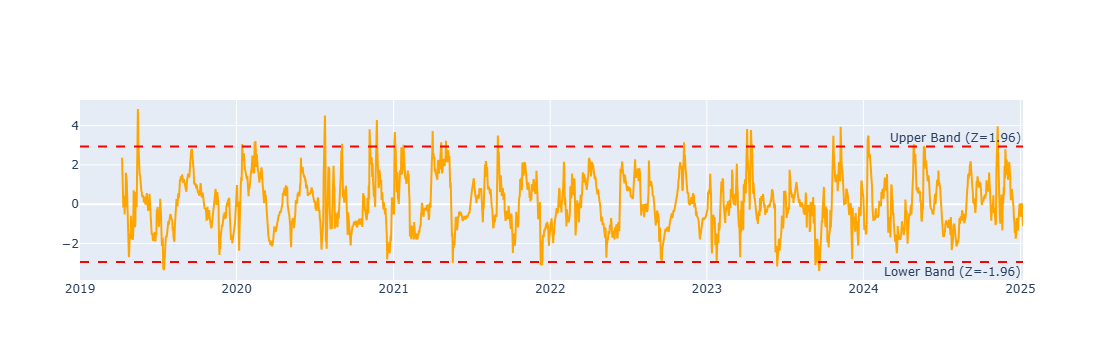

In [59]:

fig3 = go.Figure()

# Add Z-Score trace
fig3.add_trace(go.Scatter(x=data.index, y=data["Z-Score"], mode="lines", name="Z-Score", line=dict(color="orange")))

# Add UPPER and LOWER band lines
fig3.add_hline(y=UPPER, line_dash="dash", line_color="red", annotation_text="Upper Band (Z=1.96)", annotation_position="top right")
fig3.add_hline(y=LOWER, line_dash="dash", line_color="red", annotation_text="Lower Band (Z=-1.96)", annotation_position="bottom right")

fig3.show()


In [55]:
pf.stats()

C:\Users\henry\AppData\Local\Temp\ipykernel_12796\3705677322.py:1: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001407F6B2340>. Pass column to select a single column/group.



Start                                2019-01-01 00:00:00
End                                  2025-01-07 00:00:00
Period                                2199 days 00:00:00
Start Value                                        100.0
End Value                                     132.027405
Total Return [%]                               32.027405
Benchmark Return [%]                         2361.849661
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                               57.734276
Max Drawdown Duration                 1151 days 12:00:00
Total Trades                                        63.0
Total Closed Trades                                 63.0
Total Open Trades                                    0.0
Open Trade PnL                                       0.0
Win Rate [%]                                   50.793651
Best Trade [%]                                 57.329801
Worst Trade [%]                